In [1]:
import pandas as pd
import numpy as np
import datetime
from EvGym import config

In [2]:
df_elaad = df_elaad = pd.read_csv("data/elaadnl_open_ev_datasets.csv", parse_dates = ["UTCTransactionStart", "UTCTransactionStop"])
df_elaad = df_elaad.rename(columns = config.elaad_rename)

In [3]:
df_elaad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session               10000 non-null  int64         
 1   ChargePoint           10000 non-null  object        
 2   Connector             10000 non-null  int64         
 3   starttime_parking     10000 non-null  datetime64[ns]
 4   endtime_parking       10000 non-null  datetime64[ns]
 5   StartCard             10000 non-null  object        
 6   connected_time_float  10000 non-null  float64       
 7   charged_time_float    10000 non-null  float64       
 8   total_energy          10000 non-null  float64       
 9   max_power             10000 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 781.4+ KB


In [4]:
df_elaad.head()

,session,ChargePoint,Connector,starttime_parking,endtime_parking,StartCard,connected_time_float,charged_time_float,total_energy,max_power
0,3491779,0abf481c2d3f5866a8fc7feaae460fd0,1,2019-08-27 14:52:00,2019-08-27 17:58:00,0c24de2f8216313f75daf876ec7c2223e17c866462ae41...,3.11,3.10,9.86,3.342
1,3326963,a22a6a745ff09431c3a0cef7373042ee,2,2019-03-01 10:14:00,2019-03-01 13:13:00,fd31273615db1421e4be23b51db9f1c5c904ebed131b5d...,3.00,3.00,9.38,3.440
2,3469263,f4f5e5fbf8297d4889e49f10942b030b,1,2019-07-31 12:54:00,2019-07-31 13:21:00,f876668fd30216c9054a890007143b4d40d13ddd9234c7...,0.46,0.46,1.45,3.160
3,3429356,0f87094588f6330a84f30797f0458fc8,1,2019-06-16 10:55:00,2019-06-16 14:35:00,06776db669a8f444bf7f81edc7fcf6c18c51bfd90eed2f...,3.65,3.65,38.77,10.813
4,3332751,77f3b31920754dac44d2b7400f16bca3,1,2019-03-07 21:21:00,2019-03-08 07:22:00,f88e7e074d5476d4e8a532ae1e1966de2d3f333f3c4453...,10.03,7.15,26.14,3.884


In [5]:
df_elaad["start_hour"] = df_elaad["starttime_parking"].dt.hour
df_elaad["day_no"] = (pd.to_datetime(df_elaad["starttime_parking"].dt.date) - datetime.datetime(year = 2019, month = 1, day = 1)).dt.days

# Clean vehicles that have higher charged_time than connected time
df_elaad["charged_time_float"] = np.minimum(df_elaad["charged_time_float"], df_elaad["connected_time_float"])

df_elaad["energy_supplied"] = np.minimum(config.alpha_c * config.eta_c * df_elaad["charged_time_float"], config.B * config.FINAL_SOC)
df_elaad["soc_arr"] = (config.FINAL_SOC - df_elaad["energy_supplied"]/ (config.B))


df_elaad["charged_time"] = np.ceil(df_elaad["charged_time_float"]) 
df_elaad["connected_time"] = np.ceil(df_elaad["connected_time_float"])

df_elaad["ts_arr"] = np.floor((df_elaad["starttime_parking"] - config.starttime_min).dt.total_seconds() / config.timestep)

if config.timestep == 3600:
    # This way it is consistent with connected_time
    df_elaad["ts_dep"] = df_elaad["ts_arr"] + df_elaad["connected_time"]
else:
    df_elaad["ts_dep"] = np.ceil((df_elaad["endtime_parking"] - starttime_min).dt.total_seconds() / config.timestep)
df_elaad["ts_soj"] = df_elaad["ts_dep"] - df_elaad["ts_arr"]
df_elaad["laxity"] = df_elaad["connected_time"] - (config.FINAL_SOC - df_elaad["soc_arr"]) * config.B / (config.alpha_c*config.eta_c)
df_elaad["depart_hour"] = df_elaad["start_hour"] + df_elaad["connected_time"] # Look how 
df_elaad["xi"] = df_elaad["laxity"] * config.psi * config.alpha_c
df_elaad["laxity_float"] = df_elaad["connected_time_float"] - (config.FINAL_SOC - df_elaad["soc_arr"]) * config.B / (config.alpha_c*config.eta_c)

df_elaad = df_elaad.sort_values(by = ["ts_arr", "ts_dep"]).reset_index(drop = True)

In [6]:
df_elaad.describe()

,session,Connector,connected_time_float,charged_time_float,total_energy,max_power,start_hour,day_no,energy_supplied,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04
mean,3.452817e+06,1.360300,5.822735,2.878022,13.635216,5.589366,12.412600,190.979600,28.608123,0.612398,3.355300,6.328300,171155.923000,171162.251300,6.328300,3.674485e+00,18.740900,1.980143e+01,3.168920e+00
std,1.076139e+05,0.480111,7.096361,2.644282,14.282036,3.333663,4.532131,110.531348,20.586961,0.257337,2.650125,7.093627,2652.843492,2653.132903,7.093627,6.334915e+00,9.166023,3.413822e+01,6.335457e+00
min,3.261657e+06,1.000000,0.020000,0.020000,0.100000,0.167000,0.000000,0.000000,0.215600,0.000000,1.000000,1.000000,166560.000000,166568.000000,1.000000,-4.440892e-16,2.000000,-2.393152e-15,-8.881784e-16
25%,3.360979e+06,1.000000,1.510000,1.250000,4.530000,3.398000,9.000000,93.000000,13.475000,0.498375,2.000000,2.000000,168804.000000,168808.750000,2.000000,5.300000e-01,13.000000,2.856117e+00,0.000000e+00
50%,3.452182e+06,1.000000,3.380000,2.240000,7.830000,3.640000,12.000000,190.000000,24.147200,0.668160,3.000000,4.000000,171128.000000,171133.500000,4.000000,9.600000e-01,16.000000,5.173344e+00,3.200000e-01
75%,3.547667e+06,2.000000,8.410000,3.500000,18.262500,7.277750,16.000000,294.000000,37.730000,0.801562,4.000000,9.000000,173622.250000,173629.000000,9.000000,4.801484e+00,21.000000,2.587472e+01,4.410000e+00
max,3.634120e+06,2.000000,161.170000,25.670000,93.929000,22.500000,23.000000,364.000000,77.600000,0.967305,26.000000,162.000000,175317.000000,175336.000000,162.000000,1.548015e+02,175.000000,8.342098e+02,1.539715e+02


In [7]:
df_elaad[["connected_time", "ts_soj"]].describe()

,connected_time,ts_soj
count,10000.000000,10000.000000
mean,6.328300,6.328300
std,7.093627,7.093627
min,1.000000,1.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,9.000000,9.000000
max,162.000000,162.000000


In [8]:
df_elaad[["depart_hour"]].describe()

,depart_hour
count,10000.000000
mean,18.740900
std,9.166023
min,2.000000
25%,13.000000
50%,16.000000
75%,21.000000
max,175.000000


In [9]:
df_elaad.to_csv("data/df_elaad_preproc.csv", index = False)

In [9]:
df_elaad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session               10000 non-null  int64         
 1   ChargePoint           10000 non-null  object        
 2   Connector             10000 non-null  int64         
 3   starttime_parking     10000 non-null  datetime64[ns]
 4   endtime_parking       10000 non-null  datetime64[ns]
 5   StartCard             10000 non-null  object        
 6   connected_time_float  10000 non-null  float64       
 7   charged_time_float    10000 non-null  float64       
 8   total_energy          10000 non-null  float64       
 9   max_power             10000 non-null  float64       
 10  start_hour            10000 non-null  int64         
 11  day_no                10000 non-null  int64         
 12  energy_supplied       10000 non-null  float64       
 13  soc_arr          

In [10]:
df_elaad.describe()

,session,Connector,connected_time_float,charged_time_float,total_energy,max_power,start_hour,day_no,energy_supplied,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04
mean,3.452817e+06,1.360300,5.822735,2.878022,13.635216,5.589366,12.412600,190.979600,28.608123,0.612398,3.355300,6.328300,171155.923000,171162.251300,6.328300,3.674485e+00,18.740900,1.980143e+01,3.168920e+00
std,1.076139e+05,0.480111,7.096361,2.644282,14.282036,3.333663,4.532131,110.531348,20.586961,0.257337,2.650125,7.093627,2652.843492,2653.132903,7.093627,6.334915e+00,9.166023,3.413822e+01,6.335457e+00
min,3.261657e+06,1.000000,0.020000,0.020000,0.100000,0.167000,0.000000,0.000000,0.215600,0.000000,1.000000,1.000000,166560.000000,166568.000000,1.000000,-4.440892e-16,2.000000,-2.393152e-15,-8.881784e-16
25%,3.360979e+06,1.000000,1.510000,1.250000,4.530000,3.398000,9.000000,93.000000,13.475000,0.498375,2.000000,2.000000,168804.000000,168808.750000,2.000000,5.300000e-01,13.000000,2.856117e+00,0.000000e+00
50%,3.452182e+06,1.000000,3.380000,2.240000,7.830000,3.640000,12.000000,190.000000,24.147200,0.668160,3.000000,4.000000,171128.000000,171133.500000,4.000000,9.600000e-01,16.000000,5.173344e+00,3.200000e-01
75%,3.547667e+06,2.000000,8.410000,3.500000,18.262500,7.277750,16.000000,294.000000,37.730000,0.801562,4.000000,9.000000,173622.250000,173629.000000,9.000000,4.801484e+00,21.000000,2.587472e+01,4.410000e+00
max,3.634120e+06,2.000000,161.170000,25.670000,93.929000,22.500000,23.000000,364.000000,77.600000,0.967305,26.000000,162.000000,175317.000000,175336.000000,162.000000,1.548015e+02,175.000000,8.342098e+02,1.539715e+02


In [11]:
df_elaad["session"].nunique()

10000

In [12]:
ts_max = df_elaad["ts_dep"].max()
ts_min = df_elaad["ts_arr"].min()
delta_ts = ts_max -ts_min
delta_ts / 24

365.6666666666667

In [13]:
print(df_elaad["starttime_parking"].min())
print(df_elaad["endtime_parking"].max())

2019-01-01 00:30:00
2020-01-01 16:00:00


In [14]:
df_elaad.head()

,session,ChargePoint,Connector,starttime_parking,endtime_parking,StartCard,connected_time_float,charged_time_float,total_energy,max_power,...,soc_arr,charged_time,connected_time,ts_arr,ts_dep,ts_soj,laxity,depart_hour,xi,laxity_float
0,3261657,e62c50d1be0a2f80ec51d471f9630a4e,2,2019-01-01 00:30:00,2019-01-01 08:24:00,826d337c1d84900452edfcb27a3fb11bcbd06f35da8406...,7.91,1.00,6.53,9.818,...,0.835250,1.0,8.0,166560.0,166568.0,8.0,7.00,8.0,37.722302,6.910000e+00
1,3262038,9bae10789a789973cc7f05d2a96df76f,1,2019-01-01 10:36:00,2019-01-01 12:52:00,26612ba143072faddaa884c2b04208992c5f44d97e5a24...,2.27,2.27,8.08,3.600,...,0.664118,3.0,3.0,166570.0,166573.0,3.0,0.73,13.0,3.933897,0.000000e+00
2,3262129,5ab468315a1f42feb6d0a87307593352,1,2019-01-01 11:49:00,2019-01-01 17:50:00,8478920deafe847713d1707d8f71a043c59fa066e55020...,6.02,3.75,11.56,3.400,...,0.464688,4.0,7.0,166571.0,166578.0,7.0,3.25,18.0,17.513926,2.270000e+00
3,3262170,00fa448dfcba79a12a3cea56fb48d63f,2,2019-01-01 12:22:00,2019-01-01 14:29:00,e8e1953d3e6221f971ce3299d2fa8275cdc9e7700e2b39...,2.12,0.87,3.84,7.973,...,0.852768,1.0,3.0,166572.0,166575.0,3.0,2.13,15.0,11.478357,1.250000e+00
4,3262208,e35645c6b4adb10224ecfbdff6bc5473,1,2019-01-01 12:51:00,2019-01-01 15:16:00,6490d53fbbe95d74592928292858f9b156d838f08d062e...,2.41,2.41,8.50,3.592,...,0.645253,3.0,3.0,166572.0,166575.0,3.0,0.59,15.0,3.179451,4.440892e-16


In [16]:
import matplotlib.pyplot as plt

(0.0, 1000.0)

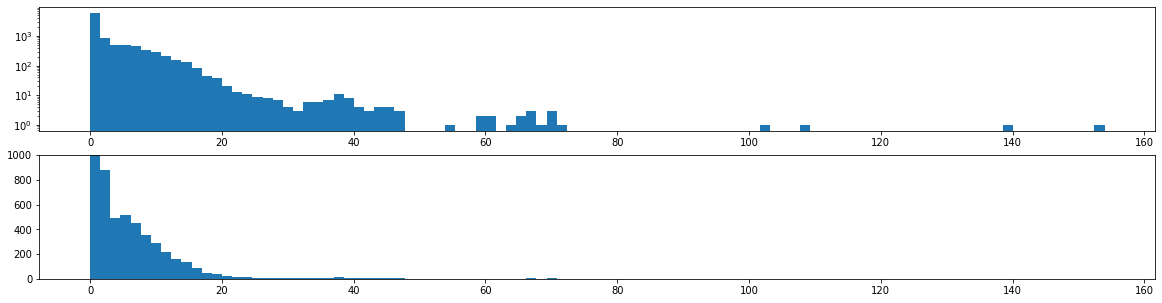

In [40]:
lax_f = df_elaad["laxity_float"] 
fig1 = plt.figure(figsize = (20, 5))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.set_yscale('log')
ax1.hist(lax_f, bins = 100);

ax2.hist(lax_f, bins = 100);
ax2.set_ylim(0, 1000)




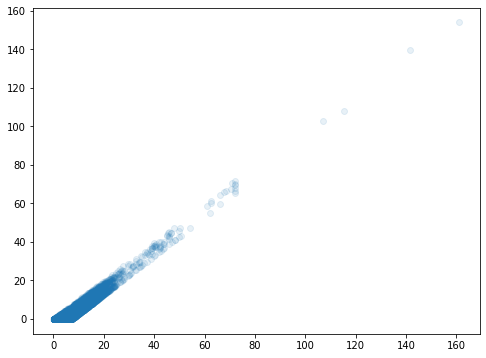

In [48]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.scatter(df_elaad["connected_time_float"], df_elaad["laxity_float"], alpha=0.1)